In [1]:
from sympy import *
from IPython.display import Math
init_printing(use_latex="mathjax", latex_mode="equation")

In [2]:
x, y, z = symbols("x y z", real=True)

# 边值问题

In [3]:
u = Function("u")
ode = Eq(-diff(u(x), x, x), 2)
ics = {
	u(x).subs(x, 0): 0,
	u(x).diff(x).subs(x, 1): 0,
}

display(ode)
for ic in [Eq(lh, rh) for lh, rh in ics.items()]:
	display(ic)

   2          
  d           
-───(u(x)) = 2
   2          
 dx           

u(0) = 0

⎛d       ⎞│       
⎜──(u(x))⎟│    = 0
⎝dx      ⎠│x=1    

# 精确解

In [4]:
import sympy.solvers.ode
exact_sol = sympy.solvers.ode.dsolve(
	eq = ode,
	func = u(x),
	ics = ics
).args[1]
display(Eq(u(x), exact_sol))

          2      
u(x) = - x  + 2⋅x

# 使用三角函数做试空间的基的伽辽金法

基函数

In [5]:
phi_sym = symbols("phi_1 phi_2")
phi = [
	sin(Rational(1, 2) * pi * x),
	sin(Rational(3, 2) * pi * x)
]

for i in range(2):
	display(Eq(phi_sym[i], phi[i]))

        ⎛π⋅x⎞
φ₁ = sin⎜───⎟
        ⎝ 2 ⎠

        ⎛3⋅π⋅x⎞
φ₂ = sin⎜─────⎟
        ⎝  2  ⎠

弱形式

In [6]:
v = Function("v")
a = integrate(u(x).diff(x) * v(x).diff(x), (x, 0, 1))
L = 2 * integrate(v(x), (x, 0, 1))

display(Eq(sympify("a(u,v)"), a))
display(Eq(sympify("L(v)"), L))

          1                     
          ⌠                     
          ⎮ d        d          
a(u, v) = ⎮ ──(u(x))⋅──(v(x)) dx
          ⎮ dx       dx         
          ⌡                     
          0                     

         1        
         ⌠        
L(v) = 2⋅⎮ v(x) dx
         ⌡        
         0        

因为$V$构成有限维线性空间，因此：

$$
\begin{aligned}
a(u,v) &= L(v) \\
\Leftrightarrow \sum_i c_i a(\phi_i, \phi_j) &= L(\phi_j), \quad j = 1,2 \\
\end{aligned}
$$

In [7]:
c = symbols("c_1 c_2")
eqs = []
for j in range(2):
	lhr = sympify(0)
	for i in range(2):
		lhr += c[i] * simplify(a.subs(u(x), phi[i]).subs(v(x), phi[j]))
	rhr = L.subs(v(x), phi[j]).subs(v(1), phi[j].subs(x, 1))

	lhr = simplify(lhr)
	rhr = simplify(rhr)

	# display(lhr)
	# display(rhr)

	eq = Eq(lhr, rhr)
	eqs.append(eq)
	display(eq)

 2       
π ⋅c₁   4
───── = ─
  8     π

   2         
9⋅π ⋅c₂    4 
─────── = ───
   8      3⋅π

求解弱形式

In [8]:
sol = solve(eqs, c)
display(sol)

⎧    32        32 ⎫
⎪c₁: ──, c₂: ─────⎪
⎨     3          3⎬
⎪    π       27⋅π ⎪
⎩                 ⎭

In [9]:
sin_sol = sum([sol[c[i]]*phi[i] for i in range(2)])
display(Eq(sympify("u"), sin_sol))

          ⎛π⋅x⎞         ⎛3⋅π⋅x⎞
    32⋅sin⎜───⎟   32⋅sin⎜─────⎟
          ⎝ 2 ⎠         ⎝  2  ⎠
u = ─────────── + ─────────────
          3               3    
         π            27⋅π     

检验是否满足变分形式$(R,v)=0$和边界条件

In [10]:
R_sym = symbols("R")
R = simplify((ode.args[1] - ode.args[0]).subs(u(x), sin_sol))
display(Eq(R_sym, R))

        ⎛     ⎛π⋅x⎞      ⎛3⋅π⋅x⎞⎞    
      8⋅⎜3⋅sin⎜───⎟ + sin⎜─────⎟⎟    
        ⎝     ⎝ 2 ⎠      ⎝  2  ⎠⎠    
R = - ─────────────────────────── + 2
                  3⋅π                

In [11]:
for i in range(len(phi)):
	var_form = integrate(
		R * phi[i],
		(x, 0, 1)
	)
	display(Math(f"(R, \\phi_{i+1}) = " + latex(var_form)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [12]:
u_0_val = sin_sol.subs(x, 0)
display(Eq(u(0), u_0_val))

u(0) = 0

In [13]:
du_1_val = sin_sol.diff(x).subs(x, 1)
display(Eq(u(x).diff(x).subs(x, 1), du_1_val))

⎛d       ⎞│       
⎜──(u(x))⎟│    = 0
⎝dx      ⎠│x=1    

# 使用有限元基函数的伽辽金法

均匀剖分$[0,1]$

In [14]:
N = 8
h = Rational(1, N)

有限元基函数

In [15]:
phi = []
i_sym = symbols("i")
def x_i(i):
	return Rational(i, N)
for i in range(N+1):
	phi.append(Piecewise(
		(Rational(1,  h) * x - Rational(x_i(i-1),  h), (x_i(i-1)<= x) & (x<x_i(i  ))),
		(Rational(1, -h) * x - Rational(x_i(i+1), -h), (x_i(i  )<=x) & (x<x_i(i+1))),
		(0, True)
	))

for i in range(N+1):
	display(Eq(sympify(f"phi_{i+1}"), phi[i]))

     ⎧8⋅x + 1  for x ≥ -1/8 ∧ x < 0
     ⎪                             
φ₁ = ⎨1 - 8⋅x  for x ≥ 0 ∧ x < 1/8 
     ⎪                             
     ⎩   0          otherwise      

     ⎧  8⋅x     for x ≥ 0 ∧ x < 1/8 
     ⎪                              
φ₂ = ⎨2 - 8⋅x  for x ≥ 1/8 ∧ x < 1/4
     ⎪                              
     ⎩   0           otherwise      

     ⎧8⋅x - 1  for x ≥ 1/8 ∧ x < 1/4
     ⎪                              
φ₃ = ⎨3 - 8⋅x  for x ≥ 1/4 ∧ x < 3/8
     ⎪                              
     ⎩   0           otherwise      

     ⎧8⋅x - 2  for x ≥ 1/4 ∧ x < 3/8
     ⎪                              
φ₄ = ⎨4 - 8⋅x  for x ≥ 3/8 ∧ x < 1/2
     ⎪                              
     ⎩   0           otherwise      

     ⎧8⋅x - 3  for x ≥ 3/8 ∧ x < 1/2
     ⎪                              
φ₅ = ⎨5 - 8⋅x  for x ≥ 1/2 ∧ x < 5/8
     ⎪                              
     ⎩   0           otherwise      

     ⎧8⋅x - 4  for x ≥ 1/2 ∧ x < 5/8
     ⎪                              
φ₆ = ⎨6 - 8⋅x  for x ≥ 5/8 ∧ x < 3/4
     ⎪                              
     ⎩   0           otherwise      

     ⎧8⋅x - 5  for x ≥ 5/8 ∧ x < 3/4
     ⎪                              
φ₇ = ⎨7 - 8⋅x  for x ≥ 3/4 ∧ x < 7/8
     ⎪                              
     ⎩   0           otherwise      

     ⎧8⋅x - 6  for x ≥ 3/4 ∧ x < 7/8
     ⎪                              
φ₈ = ⎨8 - 8⋅x   for x ≥ 7/8 ∧ x < 1 
     ⎪                              
     ⎩   0           otherwise      

     ⎧8⋅x - 7  for x ≥ 7/8 ∧ x < 1
     ⎪                            
φ₉ = ⎨9 - 8⋅x  for x ≥ 1 ∧ x < 9/8
     ⎪                            
     ⎩   0          otherwise     

逐单元$e_i$累加计算$a_{ij} = a(\phi_i, \phi_j), L_i = L(\phi_i)$

In [16]:
a = []
for i in range(N+1):
	row = []
	for j in range(N+1):
		row.append(0)
	a.append(row)
L = [0] * (N+1)

for i in range(N):
	a[i][i] += Rational(1, h)
	a[i][i+1] += Rational(1, -h)
	a[i+1][i] += Rational(1, -h)
	a[i+1][i+1] += Rational(1, h)

	L[i] += h
	L[i+1] += h

display(a)
display(L)

[[8, -8, 0, 0, 0, 0, 0, 0, 0], [-8, 16, -8, 0, 0, 0, 0, 0, 0], [0, -8, 16, -8,
 0, 0, 0, 0, 0], [0, 0, -8, 16, -8, 0, 0, 0, 0], [0, 0, 0, -8, 16, -8, 0, 0, 0
], [0, 0, 0, 0, -8, 16, -8, 0, 0], [0, 0, 0, 0, 0, -8, 16, -8, 0], [0, 0, 0, 0
, 0, 0, -8, 16, -8], [0, 0, 0, 0, 0, 0, 0, -8, 8]]

[1/8, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/4, 1/8]

构造弱形式方程组$\sum c_i a(\phi_i, \phi_j) = L(\phi_j), \forall j$

并用边界条件$c_0=0, c_N=0$替换方程组中的第0行和第N行

In [17]:
c = symbols(f"c0:{N+1}")
eqs = []
for j in range(1, N):
	lhr = 0
	for i in range(N+1):
		lhr += c[i] * a[i][j]
	rhr = L[j]

	lhr = simplify(lhr)
	rhr = simplify(rhr)

	eq = Eq(lhr, rhr)
	eqs.append(eq)

eq = Eq(c[0], 0)
eqs.insert(0, eq)

eq = Eq(c[N], 0)
eqs.append(eq)

for eq in eqs:
	display(eq)

c₀ = 0

-8⋅c₀ + 16⋅c₁ - 8⋅c₂ = 1/4

-8⋅c₁ + 16⋅c₂ - 8⋅c₃ = 1/4

-8⋅c₂ + 16⋅c₃ - 8⋅c₄ = 1/4

-8⋅c₃ + 16⋅c₄ - 8⋅c₅ = 1/4

-8⋅c₄ + 16⋅c₅ - 8⋅c₆ = 1/4

-8⋅c₅ + 16⋅c₆ - 8⋅c₇ = 1/4

-8⋅c₆ + 16⋅c₇ - 8⋅c₈ = 1/4

c₈ = 0

求解弱形式方程组

In [18]:
c_sol = solve(eqs, c)
display(c_sol)

⎧                               15               15                           
⎨c₀: 0, c₁: 7/64, c₂: 3/16, c₃: ──, c₄: 1/4, c₅: ──, c₆: 3/16, c₇: 7/64, c₈: 0
⎩                               64               64                           

⎫
⎬
⎭

将$\{c_i\}$代入$u=\sum c_i \phi_i$，得到近似解$u$

In [19]:
fem_sol = S.Zero
for i in range(len(phi)):
	fem_sol += c_sol[c[i]] * phi[i]
fem_sol = expand(simplify(fem_sol))
display(Eq(u(x), fem_sol))

       ⎧21   5⋅x                       
       ⎪── - ───  for x ≥ 3/4 ∧ x < 7/8
       ⎪32    8                        
       ⎪                               
       ⎪7   7⋅x                        
       ⎪─ - ───    for x ≥ 7/8 ∧ x < 1 
       ⎪8    8                         
       ⎪                               
       ⎪  7⋅x                          
       ⎪  ───      for x ≥ 0 ∧ x < 1/8 
       ⎪   8                           
       ⎪                               
       ⎪5⋅x   1                        
       ⎪─── + ──  for x ≥ 1/8 ∧ x < 1/4
       ⎪ 8    32                       
       ⎪                               
u(x) = ⎨3⋅x   3                        
       ⎪─── + ──  for x ≥ 1/4 ∧ x < 3/8
       ⎪ 8    32                       
       ⎪                               
       ⎪15   3⋅x                       
       ⎪── - ───  for x ≥ 5/8 ∧ x < 3/4
       ⎪32    8                        
       ⎪                               
       ⎪ x   3                         


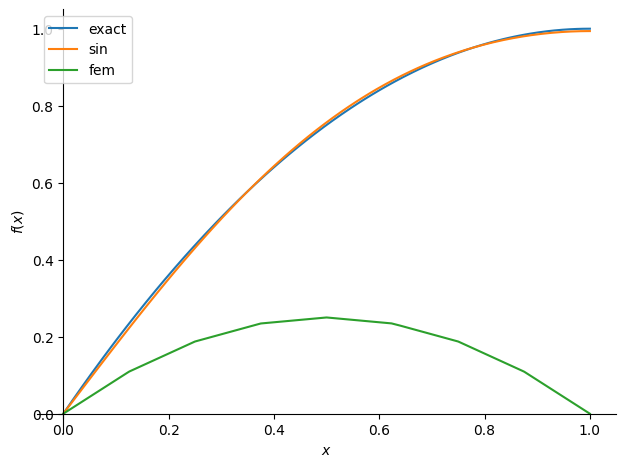

In [20]:
import sympy
from sympy.plotting import plot

exact_plot = plot(exact_sol, (x, 0, 1), legend=True, show=False, label="exact")
sin_plot = plot(sin_sol, (x, 0, 1), legend=True, show=False, label="sin")
fem_plot = plot(fem_sol, (x, 0, 1), legend=True, show=False, label="fem")

exact_plot.extend(sin_plot)
exact_plot.extend(fem_plot)
exact_plot.show()